<a href="https://colab.research.google.com/github/Goal48/NIFTY_Data_Analysis/blob/main/NIFTY50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/NIFTY 50-01-01-2007-to-31-12-2007.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,31-DEC-2007,6095.00,6167.75,6095.00,6138.60,85023208,4951.80
1,28-DEC-2007,6079.55,6098.60,6021.90,6079.70,87075023,5373.72
2,27-DEC-2007,6069.00,6110.85,6060.20,6081.50,150138294,9138.37
3,26-DEC-2007,5988.45,6085.25,5988.45,6070.75,90827443,5872.56
4,24-DEC-2007,5771.30,6001.05,5771.30,5985.10,100417081,6697.33


In [4]:
df.tail()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
244,08-JAN-2007,3983.30,3987.45,3913.00,3933.40,63615668,3590.08
245,05-JAN-2007,3990.15,4011.45,3969.65,3983.40,69146575,3558.69
246,04-JAN-2007,4027.30,4041.00,3979.80,3988.80,67096186,3446.19
247,03-JAN-2007,4007.70,4029.80,3985.00,4024.05,63826475,3291.66
248,02-JAN-2007,3966.25,4016.65,3964.95,4007.40,40789960,1929.76


In [5]:
df.shape

(249, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             249 non-null    object 
 1   Open             249 non-null    float64
 2   High             249 non-null    float64
 3   Low              249 non-null    float64
 4   Close            249 non-null    float64
 5   Shares Traded    249 non-null    int64  
 6   Turnover (₹ Cr)  249 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 13.7+ KB


In [7]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Shares Traded,0
Turnover (₹ Cr),0


In [8]:
# Clean column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]


In [9]:
# Parse date if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date")

In [10]:
# Detect close column
close_col = "close" if "close" in df.columns else df.columns[-1]

In [11]:
# Returns & Volatility
df["return"] = df[close_col].pct_change()
df["volatility"] = df["return"].rolling(20).std() * np.sqrt(252)

In [31]:
positive_ratio = (df["return"] > 0).mean()
negative_ratio = (df["return"] < 0).mean()
print("Postive Returns :", positive_ratio*100,"%")
print("Negative Returns :", negative_ratio*100,"%")

Postive Returns : 56.62650602409639 %
Negative Returns : 42.971887550200805 %


The analysis shows that approximately 56.6% of trading days have positive returns, while only 43.0% have negative returns. Since positive return days dominate, the market exhibits a bullish bias during this period. This indicates a favorable environment for long and trend-following strategies.

In [33]:
df["cum_return"] = (1 + df["return"]).cumprod()

total_return = df["cum_return"].iloc[-1] - 1
print("Total Return:", round(total_return * 100, 2), "%")


Total Return: 53.18 %


The cumulative return over the period is approximately 53.18%, meaning an investor would have gained about 53% on a buy-and-hold position. This confirms that the market experienced a strong bullish trend during this period, making it suitable for long-biased and trend-following strategies.

In [34]:
df["position"] = 1  # example: always long (you can replace with your strategy)
df["strategy_return"] = df["position"] * df["return"]

df["strategy_cum"] = (1 + df["strategy_return"]).cumprod()


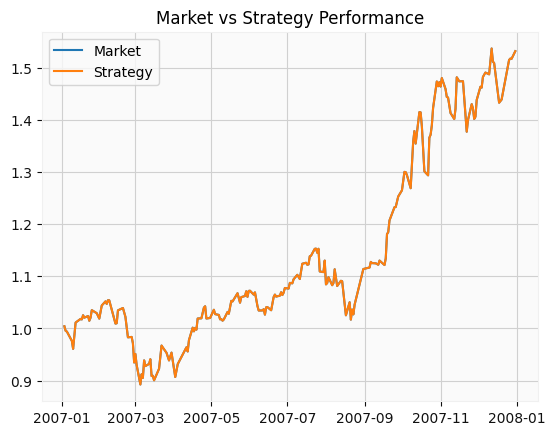

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["date"], df["cum_return"], label="Market")
plt.plot(df["date"], df["strategy_cum"], label="Strategy")
plt.legend()
plt.title("Market vs Strategy Performance")
plt.show()


In [12]:
# Moving Averages
df["ma50"] = df[close_col].rolling(50).mean()
df["ma200"] = df[close_col].rolling(200).mean()

In [13]:
# Drawdown
df["cum_return"] = (1 + df["return"]).cumprod()
df["peak"] = df["cum_return"].cummax()
df["drawdown"] = (df["cum_return"] - df["peak"]) / df["peak"]

In [14]:
# RSI
delta = df[close_col].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df["rsi"] = 100 - (100 / (1 + rs))

In [15]:
# MACD
ema12 = df[close_col].ewm(span=12, adjust=False).mean()
ema26 = df[close_col].ewm(span=26, adjust=False).mean()
df["macd"] = ema12 - ema26
df["signal"] = df["macd"].ewm(span=9, adjust=False).mean()

In [16]:
# Support & Resistance (20-day)
df["support_20"] = df[close_col].rolling(20).min()
df["resistance_20"] = df[close_col].rolling(20).max()


In [17]:
latest = df.dropna().iloc[-1]
current_price = df[close_col].iloc[-1]

In [18]:
#Market Direction
if latest["ma50"] > latest["ma200"] and current_price > latest["ma50"]:
    market_direction = "Bullish"
elif latest["ma50"] < latest["ma200"] and current_price < latest["ma50"]:
    market_direction = "Bearish"
else:
    market_direction = "Range / Sideways"

In [19]:
# Volatility Regime
vol = latest["volatility"]
if vol > df["volatility"].quantile(0.66):
    vol_regime = "High (Risk-off)"
elif vol < df["volatility"].quantile(0.33):
    vol_regime = "Low (Risk-on)"
else:
    vol_regime = "Medium"

In [20]:
#  Momentum
if latest["macd"] > latest["signal"] and latest["rsi"] > 50:
    momentum = "Positive"
elif latest["macd"] < latest["signal"] and latest["rsi"] < 50:
    momentum = "Negative"
else:
    momentum = "Weak / Mixed"

In [21]:
# Trading Levels
support = latest["support_20"]
resistance = latest["resistance_20"]


In [22]:
# Trading Plan Logic
if market_direction == "Bullish":
    direction = "Long"
    entry = current_price
    stop = support
    target = resistance + (resistance - support)
elif market_direction == "Bearish":
    direction = "Short"
    entry = current_price
    stop = resistance
    target = support - (resistance - support)
else:
    direction = "Range"
    entry = current_price
    stop = support
    target = resistance

risk = abs(entry - stop)
reward = abs(target - entry)
rr = reward / risk if risk != 0 else np.nan

In [23]:
# Position sizing example
capital = 100000        # ₹100,000
risk_per_trade = 0.01 * capital  # 1% risk
position_size = risk_per_trade / risk if risk != 0 else np.nan

In [24]:
#Summary
summary = {
    "Market Direction": market_direction,
    "Support (20d)": round(support, 2),
    "Resistance (20d)": round(resistance, 2),
    "Volatility Regime": vol_regime,
    "Max Drawdown": round(df["drawdown"].min(), 4),
    "Momentum": momentum,
    "Trade Direction": direction,
    "Entry": round(entry, 2),
    "Stop-loss": round(stop, 2),
    "Target": round(target, 2),
    "Risk-Reward": round(rr, 2),
    "Position Size (units)": round(position_size, 2)
}

summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
print(summary_df)

                   Metric     Value
0        Market Direction   Bullish
1           Support (20d)    5742.3
2        Resistance (20d)    6159.3
3       Volatility Regime    Medium
4            Max Drawdown   -0.1533
5                Momentum  Positive
6         Trade Direction      Long
7                   Entry    6138.6
8               Stop-loss    5742.3
9                  Target    6576.3
10            Risk-Reward       1.1
11  Position Size (units)      2.52


In [26]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.5 MB/s eta 0:00:00


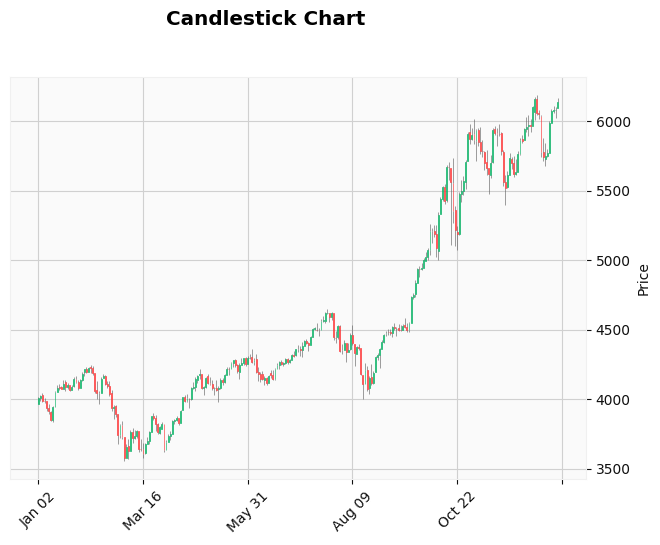

In [27]:
import mplfinance as mpf

# Ensure 'date' is a datetime object and set it as the index
df['date'] = pd.to_datetime(df['date'])
df_candlestick = df.set_index('date')

# Plotting the candlestick chart
mpf.plot(df_candlestick, type='candle', style='yahoo', title='Candlestick Chart', ylabel='Price')